# Creating a web-ready model

There are a few goals here:
    
- MVP
    - Type in a known song in the database, return the 5 most likely producers and their percentages.
    - Display the 5 most similar songs
- Nice to Have
    - All above plus
    - Ability to type in any song with spotify mp3
- Better
    - All the above plus
    - New song -> Display producer for that song.
- Best
    - All the above plus
    - Model updates on the fly based on others' input

# MVP

### Recreate the model:

In [524]:
# Standard Imports
from __future__ import print_function
import numpy as np
import pandas as pd
import os
import sys
from collections import defaultdict
from importlib import reload
from bs4 import BeautifulSoup
import requests
import scipy.stats as scs
import time
import seaborn as sns

import matplotlib.pyplot as plt

# Modeling
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import datasets, layers, models
# import keras.backend as K
# from tensorflow.keras.constraints import min_max_norm, non_neg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

# Load MongoDB
from pymongo import MongoClient
client = MongoClient()
# Access/Initiate Database
db = client['producer_db']
# Access/Initiate Table
mfcc_tab = db['mfcc']
tab = db['songs']
collection = db.tab
mfcc_collection = db.mfcc_tab

# Authorize Spotify API
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_id = os.environ['SPOTIFY_CLIENT_ID']
client_secret = os.environ['SPOTIFY_CLIENT_SECRET']
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Discogs token
discogs_token = os.environ['DISCOGS_TOKEN']

# Plotly
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import colorlover as cl
from IPython.display import HTML
plotly_username = os.environ['PLOTLY_USERNAME']
plotly_api_key = os.environ['PLOTLY_API_KEY']
plotly.tools.set_credentials_file(username=plotly_username, api_key=plotly_api_key)
#set colormap
Set3_10 = cl.scales['10']['qual']['Set3']
cm_10 = list(zip(np.linspace(0,1,10),Set3_10)) 



In [2]:
# Create a Pandas DataFrame of the Data
song_data_list = []
audio_feature = 'mfcc_highpass'
for song in mfcc_collection.find():
    try:
        song_data = (song['track'],song['artist'],song['album'],song[audio_feature],song['basic_genre'],song['producer'])
        song_data_list.append(song_data)
    except:
        pass
song_df = pd.DataFrame(song_data_list, columns = ['track','artist','album',audio_feature,'genre','producer'])
song_df = song_df[song_df[audio_feature].apply(lambda x: np.array(x).shape[1]) >= 1200] #ensures all audio features are same size.

# Make feature matrix
X = np.vstack(song_df[audio_feature].apply(lambda x: np.array(x)[:,:1200].flatten()).values)

# Make target vector, one-hot encoded vector, and y_columns - a "legend" for the vectors.
y = song_df['producer']
y_one_hot = pd.get_dummies(y).values
y_columns = np.array(pd.get_dummies(y).columns)

# Test train split.
X_train, X_test, y_train, y_test = train_test_split(X ,y_one_hot, test_size = 0.3, random_state = 440)

# Standardize
ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train)
X_test_scale = ss.transform(X_test)


# Use PCA to reduce dimensionality
pca = PCA(n_components=12)
X_train_pca = pca.fit_transform(X_train_scale)
X_test_pca = pca.transform(X_test_scale)

# Make a knn model
knn = KNeighborsClassifier(n_neighbors = 30)
knn.fit(X_train_pca, y_train)

# Convert y labels from unit vectors to integers
y_test_labels = np.argmax(y_test, axis = 1)
y_hat = knn.predict(X_test_pca)
y_hat_labels = np.argmax(np.stack(knn.predict_proba(X_test_pca))[:,:,1].T, axis = 1)


# Calculate Metrics
accuracy = (y_test_labels == y_hat_labels).sum()/y_test_labels.size
maj_class = np.argmax(y_train.sum(axis = 0))
benchmark = (y_test_labels == maj_class).sum()/y_test_labels.size # Benchmark is guessing majority class

# Print Metric
print("Producer Accuracy:\t{:.2f}".format(accuracy))
print("Benchmark:\t\t{:.2f}".format(benchmark)) 
print()


Producer Accuracy:	0.43
Benchmark:		0.08



In [96]:
distances, indices = knn.kneighbors(X_test_pca[0:1,:1200])

In [97]:
is_neighbor = knn.kneighbors_graph(X_test_pca[0:1,:1200], n_neighbors = 5)

In [98]:
my_df = pd.DataFrame([(1,2,3),(4,5,6),(1,2,3),(4,5,6),(1,2,3),(4,5,6),(1,2,3),(4,5,6)],columns=['A','B','C'])

In [99]:
top_producers = np.argsort(np.vstack(knn.predict_proba(X_test_pca[0:1,:1200]))[:,1])[::-1]

In [100]:
test_array = np.random.rand(3,4)
test_array

array([[0.14084063, 0.52480538, 0.10881116, 0.54927421],
       [0.28411038, 0.73124733, 0.3609393 , 0.07743544],
       [0.67944859, 0.94568109, 0.00622502, 0.58103205]])

In [101]:
np.argsort(test_array, axis = 1)

array([[2, 0, 1, 3],
       [3, 0, 2, 1],
       [2, 3, 0, 1]])

In [102]:
song_df.head()

,track,artist,album,mfcc_highpass,genre,producer
0,Act Naturally,Buck Owens and the Buckaroos,The Best of Buck Owens,"[[-106.0409148180113, -114.71286150048788, -15...",country,George Martin
1,Alfie,Cilla Black,Cilla Black singles chronology,"[[-115.42859278964515, -133.7129072512278, -20...",pop,George Martin
2,Amber Cascades,America,Hideaway,"[[-132.7895650459967, -149.0103345463059, -205...",country,George Martin
3,Anyone Who Had a Heart,Dionne Warwick,Anyone Who Had a Heart,"[[-417.5704948136371, -400.7918664259179, -375...",soul,George Martin
4,Baby It's You,The Shirelles,Baby It's You,"[[-199.51104878028514, -215.14526944983157, -2...",soul,George Martin


In [71]:
X_scale = ss.transform(X)
X_pca = pca.transform(X_scale)

knn = KNeighborsClassifier(n_neighbors = 30)
knn.fit(X_pca, y_one_hot)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=30, p=2,
           weights='uniform')

In [64]:
song_df.head()

,track,artist,album,mfcc_highpass,genre,producer
0,Act Naturally,Buck Owens and the Buckaroos,The Best of Buck Owens,"[[-106.0409148180113, -114.71286150048788, -15...",country,George Martin
1,Alfie,Cilla Black,Cilla Black singles chronology,"[[-115.42859278964515, -133.7129072512278, -20...",pop,George Martin
2,Amber Cascades,America,Hideaway,"[[-132.7895650459967, -149.0103345463059, -205...",country,George Martin
3,Anyone Who Had a Heart,Dionne Warwick,Anyone Who Had a Heart,"[[-417.5704948136371, -400.7918664259179, -375...",soul,George Martin
4,Baby It's You,The Shirelles,Baby It's You,"[[-199.51104878028514, -215.14526944983157, -2...",soul,George Martin


(array([ 4.,  4.,  4.,  9., 21., 23., 40., 51., 83., 76., 88., 74., 72.,
        81., 67., 56., 45., 32., 32., 23., 24., 20., 16.,  9.,  6.,  2.,
         2.,  0.,  1.,  2.]),
 array([ 931.86984705,  982.92897116, 1033.98809527, 1085.04721937,
        1136.10634348, 1187.16546759, 1238.2245917 , 1289.2837158 ,
        1340.34283991, 1391.40196402, 1442.46108812, 1493.52021223,
        1544.57933634, 1595.63846045, 1646.69758455, 1697.75670866,
        1748.81583277, 1799.87495688, 1850.93408098, 1901.99320509,
        1953.0523292 , 2004.1114533 , 2055.17057741, 2106.22970152,
        2157.28882563, 2208.34794973, 2259.40707384, 2310.46619795,
        2361.52532206, 2412.58444616, 2463.64357027]),
 <a list of 30 Patch objects>)

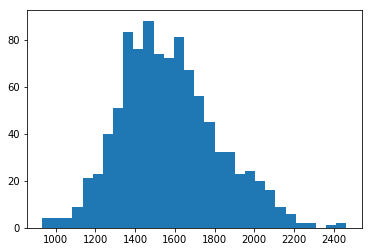

In [59]:
plt.hist(X_pca[:,11].flatten(), bins = 30)

In [105]:
X_test_pca[0:1,:1200].shape

(1, 12)

In [106]:
# Takes a PCA vector and return top producers
top_producers = y_columns[np.argsort(np.vstack(knn.predict_proba(X_test_pca[0:1,:1200]))[:,1])[::-1]]
top_producers

array(['Rick Rubin', 'Paul Epworth', 'Dr. Dre', 'RZA', 'George Martin',
       'Brian Eno', 'Stock Aitken Waterman', 'Roy Thomas Baker',
       'Pete Rock', 'Kanye West'], dtype=object)

In [30]:
# Takes a PCA vector and returns top songs

distances, indices = knn.kneighbors(np.array([[50,50,50,50,50,50,50,50,50,50,50,50]]))
song_df.loc[indices.flatten().tolist()[:5]]

,track,artist,album,mfcc_highpass,genre,producer
534,Staying Fat,Bloc Party,Bloc Party,"[[-44.57645748041316, -52.77683181545641, -73....",pop,Paul Epworth
176,Hell Yea,Obie Trice,Bottoms Up,"[[10.34048419474026, -12.670717682660396, -98....",hip hop,Dr. Dre
122,Can't C Me,2Pac,All Eyez on Me,"[[10.375651403535834, -5.4824673038451905, -92...",hip hop,Dr. Dre
170,Secrets,Obie Trice,Bottoms Up,"[[33.05360338182072, 7.774573215040971, -102.4...",hip hop,Dr. Dre
582,Darkest Place,Plan B,The Defamation of Strickland Banks,"[[-48.682799772834414, -63.59993311991465, -11...",None,Paul Epworth


In [35]:
X_pca.std()

2049.18747870678

In [166]:
artist = None
track = None

In [167]:
song_df[((song_df['artist']==artist) if artist else 1) 
        & (song_df['track']==track)]

,track,artist,album,mfcc_highpass,genre,producer


In [103]:
from sklearn.pipeline import Pipeline

In [89]:
# Write a function that takes a track and artist and returns list of 5 producers and dataframe of 5 (track, artist, album, producer) entries

def query_knn(song_df, ss, knn, y_columns, track, artist=None, album=None):
    query_df = song_df[
                      (song_df['track']==track) &
                      (song_df['artist']==artist if artist else 1) &
                      (song_df['album']==album if album else 1)
                     ]
    audio_data = query_df.iloc[0]['mfcc_highpass']
    flat_audio_data = np.array(audio_data)[:,:1200].flatten().reshape(1,-1)
    print(flat_audio_data.shape)
    X_query_pca = pca.transform(ss.transform(flat_audio_data))
    print(X_query_pca)
    top_producers = y_columns[np.argsort(np.vstack(knn.predict_proba(X_query_pca))[:,1])[::-1]]

    distances, indices = knn.kneighbors(X_query_pca)
    print(indices)
    top_songs = song_df.loc[indices.flatten().tolist()[:5]][['track','artist','album','producer']]
    top_songs['distance'] = distances.flatten()[:5]
    return top_producers, top_songs

In [93]:
top_producers, top_songs = query_knn(song_df, ss, knn, y_columns, track='Hymn')
top_producers

(1, 24000)
[[  8.03360782   9.42277472  14.96685391  19.18657558 -42.51323646
    7.09033844 -11.39860995   1.52157473 -13.88262467 -22.01063886
  -22.68022351  -6.48921458]]
[[ 12 481 546  26 479 486 459 666 966 323 508 482  17 782 681 680 318 158
  544 501  29 340 619 593 426 702 435 502   7 487]]


array(['Stock Aitken Waterman', 'Paul Epworth', 'George Martin',
       'Pete Rock', 'Brian Eno', 'Kanye West', 'Roy Thomas Baker',
       'Dr. Dre', 'Rick Rubin', 'RZA'], dtype=object)

In [94]:
top_songs

,track,artist,album,producer,distance
12,Hymn,Ultravox,Quartet,George Martin,1.476610e-13
481,Boom Boom Satellite,Sigue Sigue Sputnik,Dress for Excess,Stock Aitken Waterman,4.461858e+01
546,Ghost,Lianne La Havas,Blood,Paul Epworth,5.034530e+01
26,Something Tells Me (Something's Gonna Happen T...,Cilla Black,Cilla Black singles chronology,George Martin,5.050622e+01
479,Who Could Ask for Anything More?,Boy Krazy,Boy Krazy,Stock Aitken Waterman,5.558387e+01


In [92]:
song_df.sample(20)

,track,artist,album,mfcc_highpass,genre,producer
811,Here Comes the Gravediggaz,Gravediggaz,6 Feet Deep,"[[-325.46069115854124, -314.2303934540428, -34...",hip hop,RZA
51,You've Got To Hide Your Love Away,the Beatles,20 Greatest Hits,"[[-282.2831612029979, -292.63676738656136, -33...",rock,George Martin
322,Strangers When We Meet,David Bowie,1. Outside,"[[-70.91511059540349, -86.2553956957963, -145....",rock,Brian Eno
761,All I'm Giving (feat. David Dam) [Radio Edit],Chris Brown,Before the Party,"[[-19.864762071374646, -29.131329746403775, -8...",None,Kanye West
75,To Each His Own - Live Version,America,Live,"[[-201.4959375857263, -197.5275249796764, -206...",country,George Martin
316,Life During Wartime - 2005 Remastered Version,Talking Heads,Fear of Music,"[[-168.19140377221478, -184.4793908749072, -24...",rock,Brian Eno
632,Genesis,De La Soul,And the Anonymous Nobody...,"[[-222.71756596099848, -237.5803140511843, -28...",hip hop,Pete Rock
203,Aeroplane,Red Hot Chili Peppers,One Hot Minute,"[[-21.13435077757185, -35.449959302930075, -10...",rock,Rick Rubin
868,Freakshow,Method Man & Redman,Blackout!,"[[-58.561402151842856, -78.01425508703323, -14...",hip hop,RZA
103,How We Do,The Game featuring 50 Cent,The Documentary,"[[-285.48173165338903, -300.4269797071679, -36...",None,Dr. Dre


In [109]:
pipeline = Pipeline(steps=[('ss',ss),
                     ('pca',pca),
                     ('knn',knn.predict_proba)])

TypeError: Last step of Pipeline should implement fit. '<bound method KNeighborsClassifier.predict_proba of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=30, p=2,
           weights='uniform')>' (type <class 'method'>) doesn't

In [114]:
pipeline = Pipeline([('ss',StandardScaler()),
                     ('pca',PCA(n_components=12))
                    ]
                   )

In [115]:
pipeline.fit_transform(X)

array([[ -5.92556759,   9.26195634, -38.40809255, ...,  16.4970865 ,
         -5.10018973, -21.78687732],
       [ 42.28521514,  22.35556663, -26.77753632, ...,  32.42379448,
         -1.69549867, -14.76777689],
       [ 14.22671922,  15.77747332,  -9.53423042, ...,  -6.48067064,
        -18.02432766,   5.41703778],
       ...,
       [-12.78340473,   1.73643461, -28.38017091, ..., -20.60415641,
          3.13398035,  -9.29451311],
       [ 44.70922682, -11.88054257, -59.27307355, ..., -14.49855103,
         -6.23283598,   5.84981373],
       [-20.07065575,   2.42453256, -25.94165586, ...,  -6.2041021 ,
          1.09094184,  -9.27239941]])

In [403]:
import src.knn_modeling as km

In [475]:
reload(km)

<module 'src.knn_modeling' from '/Users/Maxwell/galvanize/production-value/src/knn_modeling.py'>

In [476]:
pv = km.ProductionValue(collection = mfcc_collection, sp = sp, discogs_token = discogs_token)

In [477]:
pv.fit_knn('mfcc_highpass')

In [478]:
pv.to_pickle('does_this_work.pickle')

In [479]:
pv2 = km.ProductionValue(collection = mfcc_collection, sp = sp, discogs_token = discogs_token)
pv2.read_pickle('does_this_work.pickle')
pv2.song_df.head()

,track,artist,album,mfcc_highpass,genre,producer
0,Act Naturally,Buck Owens and the Buckaroos,The Best of Buck Owens,"[[-106.0409148180113, -114.71286150048788, -15...",country,George Martin
1,Alfie,Cilla Black,Cilla Black singles chronology,"[[-115.42859278964515, -133.7129072512278, -20...",pop,George Martin
2,Amber Cascades,America,Hideaway,"[[-132.7895650459967, -149.0103345463059, -205...",country,George Martin
3,Anyone Who Had a Heart,Dionne Warwick,Anyone Who Had a Heart,"[[-417.5704948136371, -400.7918664259179, -375...",soul,George Martin
4,Baby It's You,The Shirelles,Baby It's You,"[[-199.51104878028514, -215.14526944983157, -2...",soul,George Martin


In [480]:
a, b, c, = pv2.query('money', artist='pink floyd', use_spotify=True)

money artist:pink floyd


/Users/Maxwell/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [481]:
a

array(['Rick Rubin', 'Dr. Dre', 'Paul Epworth', 'RZA',
       'Stock Aitken Waterman', 'Kanye West', 'Roy Thomas Baker',
       'Pete Rock', 'Brian Eno', 'George Martin'], dtype=object)

In [482]:
b

,track,artist,album,producer,distance
2,Amber Cascades,America,Hideaway,George Martin,47.203039
25,Sister Golden Hair,America,Hearts,George Martin,47.658202
637,CBGBS,De La Soul,And the Anonymous Nobody...,Pete Rock,49.674801
332,This Is That,David Byrne,American Utopia,Brian Eno,50.269179
82,Smile of the Beyond,Mahavishnu Orchestra,Apocalypse,George Martin,50.498442


In [483]:
c

'Pink Floyd'

In [444]:
pv.song_df.head()

,track,artist,album,mfcc_highpass,genre,producer
0,Act Naturally,Buck Owens and the Buckaroos,The Best of Buck Owens,"[[-106.0409148180113, -114.71286150048788, -15...",country,George Martin
1,Alfie,Cilla Black,Cilla Black singles chronology,"[[-115.42859278964515, -133.7129072512278, -20...",pop,George Martin
2,Amber Cascades,America,Hideaway,"[[-132.7895650459967, -149.0103345463059, -205...",country,George Martin
3,Anyone Who Had a Heart,Dionne Warwick,Anyone Who Had a Heart,"[[-417.5704948136371, -400.7918664259179, -375...",soul,George Martin
4,Baby It's You,The Shirelles,Baby It's You,"[[-199.51104878028514, -215.14526944983157, -2...",soul,George Martin


In [438]:
import pickle

In [459]:
pv2 = km.ProductionValue(mfcc_collection, sp, discogs_token)

In [467]:
my_list = ['never','gonna','give','you','up']

In [468]:
with open('does_this_work.pickle', 'wb') as f:
    pickle.dump(my_list, f, pickle.HIGHEST_PROTOCOL)

In [469]:
with open('does_this_work.pickle', 'rb') as f:
    loaded_obj = pickle.load(f)

In [470]:
loaded_obj

['never', 'gonna', 'give', 'you', 'up']

In [157]:
top_producers, top_songs = pv.query('Alfie')

In [158]:
top_producers

array(['George Martin', 'Brian Eno', 'Pete Rock', 'Dr. Dre',
       'Roy Thomas Baker', 'Paul Epworth', 'Kanye West',
       'Stock Aitken Waterman', 'Rick Rubin', 'RZA'], dtype=object)

In [252]:
from src.audio_processing import load_mp3_from_url, mfcc_highpass

In [394]:
def query_spotify(track, artist=None, album=None):
    query = track + (' artist:{}'.format(artist) if artist else '') + (' album:{}'.format(album) if album else '')
    print(query)
    search = sp.search(q=query, type='track')
    song = search['tracks']['items'][0]
       
    # song info
    preview_url = song['preview_url']
    # check for mp3
    if not preview_url:
        print('No audio file available for track:'+query)
        return None
    
    # more song info
    song_id = song['id']
    track = song['name']
    album = song['album']['name']
    artist = song['artists'][0]['name']
    artist_id = song['artists'][0]['id']
    
    # Lookup producer on Discogs
    producer_discogs = find_one_producer(discogs_token, track, album=album, artist=artist, year='', N=10)

    # Get genre list from artist
    genre_list = sp.artist(artist_id)['genres']
    
    # Use preview_url to get audio processing
    y, sr = load_mp3_from_url(preview_url)
    M = mfcc_highpass(y, sr)
    
    # Pipeline audio data
    flat_audio_data = np.array(M)[:,:1200].flatten().reshape(1,-1)
    X_query_pca = pipeline.transform(flat_audio_data)
    
    # Predict songs and producers
    top_producers = y_columns[np.argsort(np.vstack(knn.predict_proba(X_query_pca))[:,1])]
    # NEED TO ADD PROBABILITIES

    distances, indices = knn.kneighbors(X_query_pca)
    top_songs = song_df.loc[indices.flatten().tolist()[:5]][['track','artist','album','producer']]
    top_songs['distance'] = distances.flatten()[:5]
    pass

    # Add data to MongoDB
    myquery = { "producer": producer_discogs,
                "spotify_id" : song_id }

    newvalues = { "$set": {'mfcc_highpass':M.tolist(),
                           'producer':producer_discogs,
                           'spotify_id':song_id,
                           'album':album,
                           'artist':artist,
                           'preview_url':preview_url,
                           'track':track,
                           'genres':genre_list}
                }
    collection.update_one(myquery, newvalues, upsert = False) #Change this to TRUE when I deploy

    return top_producers, top_songs, producer_discogs

In [395]:
p, s, d = query_spotify('keep breathing',artist='ingrid michaelson')

keep breathing artist:ingrid michaelson


/Users/Maxwell/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [396]:
p

array(['Kanye West', 'Stock Aitken Waterman', 'Pete Rock', 'RZA',
       'Dr. Dre', 'Roy Thomas Baker', 'Rick Rubin', 'Paul Epworth',
       'Brian Eno', 'George Martin'], dtype=object)

In [397]:
s

,track,artist,album,producer,distance
305,Christmas Lights,Coldplay,Coldplay singles chronology,Brian Eno,34.172192
57,Just Got Back,Cheap Trick,All Shook Up,George Martin,35.564925
899,Strawberry,Ghostface Killah,Bulletproof Wallets,RZA,36.901566
348,Found a Job - Remastered,Talking Heads,The Best of Talking Heads,Brian Eno,36.936956
315,Jocko Homo,Devo,Q: Are We Not Men?A: We Are Devo!,Brian Eno,37.769704


In [398]:
d

'Bill Lefler'

In [260]:
y_columns

array(['Brian Eno', 'Dr. Dre', 'George Martin', 'Kanye West',
       'Paul Epworth', 'Pete Rock', 'RZA', 'Rick Rubin',
       'Roy Thomas Baker', 'Stock Aitken Waterman'], dtype=object)

In [242]:
np.array(np.array([[2,2],[2,2]]))

array([[2, 2],
       [2, 2]])

In [204]:
song = sp.search(q='never gonna give you up', type='track')['tracks']['items'][0]

In [206]:
song.keys()

dict_keys(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms', 'explicit', 'external_ids', 'external_urls', 'href', 'id', 'is_local', 'name', 'popularity', 'preview_url', 'track_number', 'type', 'uri'])

In [391]:
mfcc_collection.find_one().keys()

dict_keys(['_id', 'producer', 'spotify_id', 'MFCC', 'album', 'artist', 'preview_url', 'songs_mongs_id', 'track', 'genres', 'basic_genre', 'mfcc_highpass', 'mfcc_harmonic', 'mfcc_percussive', 'mfcc_shuffle'])

In [216]:
song['name'], song['album']['name'], song['artists'][0]['name'], song['artists'][0]['id'], song['id'], song['preview_url']

('Never Gonna Give You Up',
 'Whenever You Need Somebody',
 'Rick Astley',
 '0gxyHStUsqpMadRV0Di1Qt',
 '7GhIk7Il098yCjg4BQjzvb',
 'https://p.scdn.co/mp3-preview/22bf10aff02db272f0a053dff5c0063d729df988?cid=5157426229ce47aea8e1a6c56e231ddf')

In [236]:
sp.artist('0gxyHStUsqpMadRV0Di1Qt')['genres']

['dance pop',
 'dance rock',
 'disco',
 'europop',
 'new romantic',
 'new wave',
 'new wave pop',
 'soft rock']

In [348]:
def find_producer(discogs_token, track, album='', artist='', year='', N=10):
    """
    Takes four strings: artist, track, album, and discogs token and returns the tuple (role='Producer', name, and discogs resource_url),
    if one is returned in the first N results on discogs.

    INPUTS:
        track: STR - the name of the song
        album: STR - the name of the album
        artist: STR - the name of the artist
        year: STR - the year the song was released
        discogs_token: STR - API string for api.discogs.com
        N: INT - number of results to iterate through before giving up on finding a producer
    """

    # Use Discogs API to search for artist, track, album
    artist = artist.replace(' ','+')
    track = track.replace(' ','+')
    album = album.replace(' ','+')
    api_query = requests.get('https://api.discogs.com/database/search?track={}&artist={}&release_title={}&year={}&type=release&token={}'
                             .format(track, artist, album, year, discogs_token)).json()['results']

    # api_query is a LIST. Do the following:

    producer_list = []
    # search api_query for 'role' = 'Producer'
    for i, entry in enumerate(api_query):
        for producer in gen_key_value_extract('role', entry, 'producer', ['role','name','resource_url']):
            producer_list.append(producer)

        # check if we've found a producer yet
        if len(producer_list) > 0:
            return producer_list

        # if no Producer, GET api_subquery from the 'resource_url' field
        resource_url = list(gen_dict_extract('resource_url', entry))[0]
        api_subquery = requests.get(resource_url).json()

        # search next_api_query for 'role' = 'Producer'
        for producer in gen_key_value_extract('role', api_subquery, 'producer', ['role','name','resource_url']):
            producer_list.append(producer)

        # check if we've found a producer yet
        if len(producer_list) > 0:
            return producer_list

        # If no producer, loop back and go to the next item in api_query.
        if i>=N:
            return producer_list


def gen_key_value_extract(key, var, value, req_keys):
    """
    In a nested dictionary, var, where value in key, return req_value for keys in req_keys.

    INPUT:
        key: OBJECT - The key to match in a nested dictionary
        var: DICT - The nested dictionary to iterate through
        value: OBJECT - The desired matching value to `key`
        req_keys: LISTLIKE - a list of requested keys whose values will be returned

    OUTPUT:
        result: GENERATOR OBJECT - result returns tuples of values associated with the keys in req_keys
    """
    if hasattr(var,'items'):
        for k, v in var.items():
            if k == key:
                if value.lower() in v.lower():
                    v_list = []
                    for req_key in req_keys:
                        v_list.append(var[req_key])
                    v_tup = tuple(v_list)
                    yield v_tup
            if isinstance(v, dict):
                for result in gen_key_value_extract(key, v, value, req_keys):
                    yield result
            elif isinstance(v, list):
                for d in v:
                    for result in gen_key_value_extract(key, d, value, req_keys):
                        yield result


def gen_dict_extract(key, var):
    """
    Creates a generator object that returns all of the matching values for a `key` in a nested dictionary, `var`

    INPUT:
        key: OBJECT - key to match in nested dictionary
        var: DICT - nested dictionary

    OUTPUT:
        result: GENERATOR - generates the values wherever a key = `key` in the nested dictionary.

    """
    if hasattr(var,'items'):
        for k, v in var.items():
            if k == key:
                yield v
            if isinstance(v, dict):
                for result in gen_dict_extract(key, v):
                    yield result
            elif isinstance(v, list):
                for d in v:
                    for result in gen_dict_extract(key, d):
                        yield result



def add_producer(d, discogs_token, track, album='', artist='', year='', N=10):
    """
    Adds a 'producer' key to a dictionary, d, inplace whose corresponding value is a set of tuples containing (producer_id, producer_name) pairs from the discogs API. The producer_id comes from the discogs database url.

    INPUTS:
        d: DICT - Dictionary to append
        track: STR - the name of the song
        album: STR - the name of the album
        artist: STR - the name of the artist
        year: STR - the year the song was released
        discogs_token: STR - API string for api.discogs.com
        N: INT - number of results to iterate through before giving up on finding a producer

    OUPUTS:
        None
        Appends the current dictionary inplace

    """

    output = []
    producer_list = find_producer(track, album, artist, year, discogs_token, N=10)

    # Does role == 'Producer'
    for producer in producer_list:
        print(producer[1])
        if producer[0] == 'Producer':
            output.append(producer)
            print('Producer')

    # Does role contain 'Producer'
    if len(output) == 0:
        for producer in producer_list:
            print(producer[1])
            if 'Producer' in producer[0]:
                output.append(producer)
                print('...Producer...')

    # Does role contain 'produc'
    if len(output) == 0:
        for producer in producer_list:
            print(producer[1])
            if 'produc' in producer[0]:
                output.append(producer)
                print('...produc...')

    # Add the set of likely producers to the input dictionary
    producer_set = set()
    for producer in output:
        producer_id = int(producer[2].replace('https://api.discogs.com/artists/',''))
        producer_set.add((producer_id, producer[1]))
    d['producers'] = producer_set
    
    
def find_one_producer(discogs_token, track, album='', artist='', year='', N=10):
    producer_list = find_producer(discogs_token, track, album, artist, year, N)
    output = []

    # Does role == 'Producer'
    for producer in producer_list:
        if producer[0] == 'Producer':
            output.append(producer)

    # Does role contain 'Producer'
    if len(output) == 0:
        for producer in producer_list:
            if 'Producer' in producer[0]:
                output.append(producer)

    # Does role contain 'produc'
    if len(output) == 0:
        for producer in producer_list:
            if 'produc' in producer[0]:
                output.append(producer)
                
    return output[0][1]

In [376]:
a = find_one_producer(track = 'macarena', discogs_token=discogs_token)

In [377]:
a

'MC Rage'

In [378]:
b = find_producer(track = 'never gonna give you up', discogs_token=discogs_token)

In [379]:
b

[('Written-By, Producer',
  'Stock, Aitken & Waterman',
  'https://api.discogs.com/artists/20942')]

In [339]:
b = list(x[1] for x in a)

In [340]:
b

['Patti Pirooz', 'Dan Musselman']

In [492]:
a = np.array([0.4,0.4,0,0,0,0,0.2])

In [494]:
a.sort()
b = a[::-1]
b

array([0.4, 0.4, 0.2, 0. , 0. , 0. , 0. ])

In [497]:
np.array(list(zip(a,b)))

array([[0. , 0.4],
       [0. , 0.4],
       [0. , 0.2],
       [0. , 0. ],
       [0.2, 0. ],
       [0.4, 0. ],
       [0.4, 0. ]])

In [542]:
reload(km)

<module 'src.knn_modeling' from '/Users/Maxwell/galvanize/production-value/src/knn_modeling.py'>

In [543]:
pv = km.ProductionValue(mfcc_collection, sp, discogs_token)

In [544]:
pv.fit_knn('mfcc_highpass')

In [545]:
a,b,c = pv.query('The Drop Off', artist = 'RZA')

In [546]:
a

array([['RZA', 0.3],
       ['Pete Rock', 0.26666666666666666],
       ['Dr. Dre', 0.23333333333333334],
       ['George Martin', 0.06666666666666667],
       ['Stock Aitken Waterman', 0.03333333333333333],
       ['Rick Rubin', 0.03333333333333333],
       ['Kanye West', 0.03333333333333333],
       ['Brian Eno', 0.03333333333333333],
       ['Roy Thomas Baker', 0.0],
       ['Paul Epworth', 0.0]], dtype=object)

In [547]:
b

,track,artist,album,producer,distance
851,Chi Kung,RZA,Birth of a Prince,RZA,1.762917e-13
734,Knock Knock,Monica,After the Storm,Kanye West,4.014566e+01
857,Koto Chotan,RZA,Birth of a Prince,RZA,4.425508e+01
138,Living To Get High,Stat Quo,"ATLA: All This Life Allows, Vol. 1",Dr. Dre,4.837617e+01
890,Destiny,Northstar,Bobby Digital Presents Northstar,RZA,5.022340e+01


In [548]:
c

'RZA'

In [516]:
p = list(zip(a,b))

In [517]:
np.array(p)

array([['Stock Aitken Waterman', '0.3'],
       ['Dr. Dre', '0.16666666666666666'],
       ['Roy Thomas Baker', '0.1'],
       ['RZA', '0.1'],
       ['Rick Rubin', '0.06666666666666667'],
       ['Pete Rock', '0.06666666666666667'],
       ['Kanye West', '0.06666666666666667'],
       ['Brian Eno', '0.06666666666666667'],
       ['Paul Epworth', '0.03333333333333333'],
       ['George Martin', '0.03333333333333333']], dtype='<U21')

In [521]:
pd.DataFrame(np.stack([a,b]).T)

,0,1
0,Stock Aitken Waterman,0.3
1,Dr. Dre,0.166667
2,Roy Thomas Baker,0.1
3,RZA,0.1
4,Rick Rubin,0.0666667
5,Pete Rock,0.0666667
6,Kanye West,0.0666667
7,Brian Eno,0.0666667
8,Paul Epworth,0.0333333
9,George Martin,0.0333333
